# Synchronize to and Demodulate a QPSK Packet Received on POWDER

CyberPOWDER / Community Training 2026

> Authors (alphabetical order):
> - Cassie Jeng
> - Neal Patwari
> - Aarti Singh
> - Jie Wang
> - Meles Gebreyesus Weldegebriel

Feb 2026, Version 0.4

This python notebook provides code to operate a QPSK demodulator in postprocesing for a signal recorded at a POWDER receiver. This includes perform frequency, phase, and symbol synchronization.  

Look for the raised hand icon ✋ to see things you need to change or check in order to successfully complete this receiver code. This receiver won't run if you don't complete these sections!

You will first upload the received data zip file.

## Assignment Description

The input to the activity is from Shout. Your instructor used Shout to transmit and receive a QPSK-modulated wireless signal. In class, we will walk through the process to create the IQ samples of the transmitted signal, and then transmit this signal (via the Shout measurement framework) on POWDER over the air, while receiving it at another node. With the recorded received signal, you will perform the reception in this jupyter notebook / Google colab.

Background and protocol
The packet included the following three parts, each with a particular number of bits:

| Part 1 | Part 2 | Part 3 |
| ------ | ------ | ------ |
| Preamble (64 bits) |	Sync Word (16 bits)	| Data (476 bits, or 68 characters each 7 bits) |

For QPSK, two bits are converted to one symbol, ie, one complex number, as specified in the constellation diagram.
The constellation diagram is specified as part of the wireless digital communication protocol, and we will show a graphic later.

✋ Start by answering (for yourself, not to write down yet): What is the packet duration in _symbols_?






## Setup this Python Environment

✋ Go to the file menu on the colab File menu and `Save a Copy in Drive`.  This is because the original shared doc is a read only copy.

This python notebook came from [our github QPSK Receiver Tutorial project page](https://github.com/npatwari/QPSK-RX-Tutorial#).  

The following instructions assume you have the measurement zip file(s) from a run of Shout for a QPSK transmitter. You can get this file from the git repo above.

In colab, we have to upload any file that colab needs besides this .ipynb file.  In particular we need to load the data files.  



In [ ]:
import os

user = "npatwari"
repo = "QPSK-RX-Tutorial"

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git

General info about Colab from Google:

> To execute the code in any cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.


### Import Libraries

In [ ]:
import json
import math
import numpy as np
from scipy import signal
import h5py
import matplotlib.pyplot as plt
from matplotlib import rc
import datetime
import scipy.signal as signal
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)

## Load recorded data into the environment

Here we define some functions that load the measured data and the Shout metadata about the recording from the hdf5 file.

In [ ]:
def get_time_string(timestamp):
    '''
    Helper function to get data and time from timestamp
    INPUT: timestamp
    OUTPUT: data and time. Example: 01-04-2023, 19:50:27
    '''
    date_time = datetime.datetime.fromtimestamp(int(timestamp))
    return date_time.strftime("%m-%d-%Y, %H:%M:%S")

def JsonLoad(folder, json_file):
    '''
    Load parameters from the saved json file
    INPUT
    ----
        folder: path to the measurement folder. Example: "SHOUT/Results/Shout_meas_01-04-2023_18-50-26"
        json_file: the json file with all the specifications. Example: '/save_iq_w_tx_gold.json'
    OUTPUT
    ----
        samps_per_chip: samples per chip
        wotxrepeat: number of repeating IQ sample collection w/o transmission. Used as an input to
        traverse_dataset() func
        rxrate: sampling rate at the receiver side
    '''
    config_file = folder+'/'+json_file
    config_dict = json.load(open(config_file))[0]
    nsamps = config_dict['nsamps']
    rxrate = config_dict['rxrate']
    rxfreq = config_dict['rxfreq']
    wotxrepeat = config_dict['wotxrepeat']
    rxrepeat = config_dict['rxrepeat']
    txnodes = config_dict['txclients']
    rxnodes = config_dict['rxclients']

    return rxrepeat, rxrate, txnodes, rxnodes

def traverse_dataset(meas_folder):
    '''
    Load data from hdf5 format measurement file
    INPUT
    ----
        meas_folder: path to the measurement folder. Example: "SHOUT/Results/Shout_meas_01-04-2023_18-50-26"
    OUTPUT
    ----
        data: Collected IQ samples w/ transmission. It is indexed by the transmitter name
        noise: Collected IQ samples w/o transmission. It is indexed by the transmitter name
        txrxloc: transmitter and receiver names
    '''
    data = {}
    noise = {}
    txrxloc = {}

    dataset = h5py.File(meas_folder + '/measurements.hdf5', "r") #meas_folder
    print("Dataset meta data:", list(dataset.attrs.items()))
    for cmd in dataset.keys():
        print("Command:", cmd)
        if cmd == 'saveiq':
            cmd_time = list(dataset[cmd].keys())[0]
            print("  Timestamp:", get_time_string(cmd_time))
            print("  Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
            for rx_gain in dataset[cmd][cmd_time].keys():
                print("   RX gain:", rx_gain)
                for rx in dataset[cmd][cmd_time][rx_gain].keys():
                    print("     RX:", rx)
                    print("       Measurement items:", list(dataset[cmd][cmd_time][rx_gain][rx].keys()))
        elif cmd == 'saveiq_w_tx':
            cmd_time = list(dataset[cmd].keys())[0]
            print("  Timestamp:", get_time_string(cmd_time))
            print("  Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
            for tx in dataset[cmd][cmd_time].keys():
                print("   TX:", tx)

                if tx == 'wo_tx':
                    for rx_gain in dataset[cmd][cmd_time][tx].keys():
                        print("       RX gain:", rx_gain)
                        #print(dataset[cmd][cmd_time][tx][rx_gain].keys())
                        for rx in dataset[cmd][cmd_time][tx][rx_gain].keys():
                            print("         RX:", rx)
                            #print("           Measurement items:", list(dataset[cmd][cmd_time][tx][rx_gain][rx].keys()))
                            repeat = np.shape(dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'])[0]
                            print("         repeat", repeat)

                            samplesNotx =  dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'][:repeat, :]
                            namelist = rx.split('-')
                            noise[namelist[1]] = samplesNotx
                else:
                    for tx_gain in dataset[cmd][cmd_time][tx].keys():
                        print("     TX gain:", tx_gain)
                        for rx_gain in dataset[cmd][cmd_time][tx][tx_gain].keys():
                            print("       RX gain:", rx_gain)
                            #print(dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys())
                            for rx in dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys():
                                repeat = np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'])[0]
                                print("         RX:", rx, "; samples shape", np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples']))
                                #print("         Measurement items:", list(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx].keys()))
                                # print("         rxloc", (dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxloc'][0]))
                                # peak avg check
                                txrxloc.setdefault(tx, []).extend([rx]*repeat)
                                rxsamples = dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'][:repeat, :]
                                data.setdefault(tx, []).append(np.array(rxsamples))

        else:
            print('Unsupported command: ', cmd)

    return data, noise, txrxloc


This code loads the IQ data from a file in this folder named measurements.hdf5 and prints info about the measurements in it.  The primary data is in the first return `rx_data`, which is a python dictionary that stores all of the complex-valued measurements, indexed by the transmitter and receiver names, and repetition number.

In [ ]:
# Load parameters from the JSON file which describe what was measured
RootFolder = "QPSK-RX-Tutorial"
ShoutFolderName = "Shout_meas_09-09-2025_12-03-31"


# remove local directory if it already exists
if os.path.isdir(ShoutFolderName):
    !rm -rf {ShoutFolderName}

!unzip ./{RootFolder}/{ShoutFolderName}.zip

✋ Look in the file directory (folder icon left of the colab editor) to find the file name of the JSON file in the Shout measurement folder, and put it in for `jsonfile` here.

In [ ]:
folder = "./" + ShoutFolderName
print(folder)
jsonfile =   # For you to enter
rxrepeat, samp_rate, txlocs, rxlocs = JsonLoad(folder, jsonfile)
# Load data from the HDF5 file, save IQ sample arrays
rx_data, _, txrxloc = traverse_dataset(folder)
samp_rate = 250000.0
print(txlocs)

In [ ]:
def plotOnePSDForEachLink(rx_data, txrxloc, samp_rate=250000, repeats=4, repNum=0):
    for txname in rx_data:
        print(txname)
        for i in range(0, len(rx_data[txname]), repeats):
            plt.figure()
            # This code arbitrarily picks the 0 rep to plot.
            plt.psd(rx_data[txname][i][repNum], Fs = samp_rate/1000)

            ylimits = [-120, -50]
            plt.ylim(ylimits)
            plt.yticks(range(ylimits[0], ylimits[1],10))

            plt.grid('on')
            plt.title('TX: {} RX: {}'.format(txname, txrxloc[txname][i]))
            plt.xlabel('Frequency (kHz)')
            plt.tight_layout()
            plt.show()


# Plot all links, but just the data from the 0th repetition
# To change the repetition number, add repNum=n for n in the range 0 to the
# total number of repetitions -1.
plotOnePSDForEachLink(rx_data, txrxloc, samp_rate, repeats=4, repNum=1)

## Pick Transmitter / Receiver Pair

✋ Enter in the name of the transmitter (TX) and receiver (RX), and the number of the recording (from 0 to repeats-1), which you want to demodulate in the subsequent code.  In particular, set `txloc` and `rxloc` to two different node names that you saw listed above, or in one of the plots above. If you've looked through multiple `repNum`s, set the repNum to the one that is the best.

Please select the link that has a high SNR, ie, difference between the noise and the signal near 0 kHz. I would guess that at least a 10 dB SNR is needed to receive the signal without bit error, but more is better. Note order matters -- TX and RX names are described above in the plot titles.

In [ ]:
# Pick one received signal to demodulate
txloc =  # eg., 'cbrssdr1-ustar-comp'
rxloc =  # eg., 'cbrssdr1-meb-comp'
repNum = # eg., 0

rx_data[txloc] = np.vstack(rx_data[txloc])
rxloc_arr = np.array(txrxloc[txloc])
rx0 = rx_data[txloc][rxloc_arr==rxloc][repNum]
print('\nLink: {} to {}. Repetition Num {}.'.format(txloc, rxloc, repNum))
rx0.shape

## Low Pass Filtering to out_of_band frequency components

Since the sampling rate in our experiments is about 8 times the bandwidth of the transmitted signal, we let in a lot more noise than is required.  It is better for our synchronization methods to have a higher SNR.  So here we filter the received signal with a finite impulse response (FIR) filter.  Here we use a kaiser filter designed for our sampling and symbol rates.  Since our symbol rate is 1/8 of the sample rate, our cutoff should be more than 1/8.

In [ ]:
# Design parameters: You can change these parameters depending on the
# (normalized) bandwidth of the signal you have.
stopband_attenuation = 60.0
transition_bandwidth = 0.05
cutoff_norm = 0.15  # normalized bandwidth of the passband
# What order filter do we need?
filterN, beta = signal.kaiserord(stopband_attenuation, transition_bandwidth)
# Create the filter coefficients
taps = signal.firwin(filterN, cutoff_norm, window=('kaiser', beta))
# Use the filter on the received signal
filtered_rx0 = signal.lfilter(taps, 1.0, rx0)

# Plot psd of received signal before and after filtering
plt.figure()
fig, subfigs = plt.subplots(2,1)
subfigs[0].psd(rx0, Fs = 240, label='Before Filtering')
subfigs[0].legend()
subfigs[1].psd(filtered_rx0, Fs = 240, label='After Filtering')
subfigs[1].legend()
plt.tight_layout()
plt.show()

## Preamble and Sync Word synchronization

This section creates the same sampled preamble signal that is used by the transmitter in the transmitted signal.  The packet structure of the transmitted packet is:

0. Quiet: We put 1024 zeros (complex values 0+i0) into the transmitter signal to send first.  This is so that if the receiver starts several samples late, or if the receiver must drop a certain number of samples in order to make sure that its queue is clear from the last sampling, we can still get the start of the packet.  Also it is useful to see periods of low power before a packet starts, it makes seeing the packet in signal plots easier.
1. Preamble: The preamble is used to give the receiver time to perform frequency and symbol synchronization.  In our transmitted signal, the preamble is 16 repetitions of the bits [1, 1, 0, 0].  Because we're using QPSK (with 2 bits per symbol), these are two symbols that are opposite in phase.  The preamble is thus a total length of 64 bits or 32 symbols.
2. Sync Word: The sync word is sent next, it is set of a pseudo random bits that allows the receiver to know exactly when the data bits start.  It does not know this from the preamble because sometimes the receiver misses the start of the preamble, so it can't count on the preamble having exactly 32 symbols.
3. Data bits: These contain the unknown message that the transmitter wants to convey.

Each pair of bits are converted to one symbol. The complex value of each symbol is described in the constellation diagram. The constellation diagram is arbitrary, so it must be known and must match what was used at the transmitter.

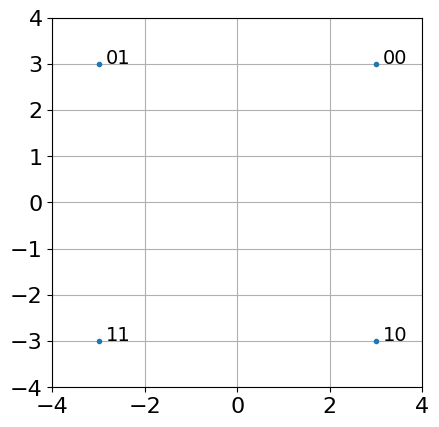


This section finds the header (the combined preamble and sync word) in the received signal.

In [ ]:
# PURPOSE: convert input data stream to signal space values for
#          a particular modulation type (as specified by the inputVec
#          and outputVec).
# INPUT: data (groups of bits)
# OUTPUT: signal space values
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('Input and Output vectors must have identical length')
    # Initialize output
    output = np.zeros(data.shape)
    # For each possible data value
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

# PURPOSE: insert 0's between samples to oversample at OS_Rate
# INPUT: x (data), OS_Rate (how frequently data occurs)
# OUTPUT: x_s (oversampled data)
def oversample(x, OS_Rate):
    # Initialize output
    x_s = np.zeros(len(x)*OS_Rate)
    x_s[::OS_Rate] = x
    return x_s

# PURPOSE: create a square root raised cosine pulse shape
# INPUT: alpha, N, Lp
# OUTPUT: pulse wave array for srrc
def SRRC(alpha, N, Lp):
    # Add epsilon to the n values to avoid numerical problems
    n = np.arange(-N*Lp+ (1e-9), N*Lp+1)
    h = np.zeros(len(n))
    coeff = 1/np.sqrt(N)
    for i, each in enumerate(n):
        sine_term = np.sin(np.pi * each * (1-alpha) / N)
        cosine_term = np.cos(np.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = np.pi * each / N
        denom_part = 1 - cosine_coeff**2
        denominator = denom_coeff * denom_part
        h[i] = coeff * numerator / denominator
    return h

# PURPOSE: Convert binary data to M-ary by making groups of log2(M)
#          bits and converting each bit to one M-ary digit.
# INPUT: Binary digit vector, with length as a multiple of log2(M)
# OUTPUT: M-ary digit vector
def binary2mary(data, M):

    k   = round(np.log2(M))
    # integer number of bits per group
    if (len(data) % k) != 0:
        print('Input to binary2mary must be divisible by log2(m).')
    datacopy = np.copy(data)
    datacopy.shape = (len(datacopy)//k, k)
    binaryValuesArray = [2**(k-1-i) for i in range(k)]
    #binaryValuesArray = 2**np.arange(k)
    print(binaryValuesArray)
    marydata = datacopy.dot(binaryValuesArray)
    return marydata

# PURPOSE: create a modulated signal with the defined header
# INPUT: A (sqrt value for modulation), N, alpha, Lp (for srrc)
# OUTPUT: modulated header signal & srrc pulse
def createHeaderSignal(A, N, alpha, Lp):

    # We defined the header as this repeating bit signal:
    preamble     = np.tile([1, 1, 0, 0], 16)
    # We define the sync word as it is given on the assignment
    syncWord = np.asarray([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0])
    combinedHeader = np.hstack([preamble, syncWord])

    ###########################################
    ### Signal Generation
    ### INPUT: binary data
    ### OUTPUT: 4-ary data (0..3) values
    data = binary2mary(combinedHeader, 4)

    ###########################################
    ### Modulation
    ### INPUT: data
    ### OUTPUT: modulated values, x
    inputVec   = [0, 1, 2, 3]
    outputVecI = [A, -A, A, -A]
    outputVecQ = [A, A, -A, -A]
    xI         = lut(data, inputVec, outputVecI)
    xQ         = lut(data, inputVec, outputVecQ)

    ###########################################
    ### Upsample
    ### INPUT: modulated values, x
    ### OUTPUT: modulated values at sampling rate, x_s
    x_s_I = oversample(xI, N)
    x_s_Q = oversample(xQ, N)

    ###########################################
    ### Pulse-shape filter
    ### INPUT: modulated values at sampling rate, x_s
    ### OUTPUT: baseband transmit signal s
    pulse = SRRC(alpha, N, Lp)
    s_0_I = np.convolve(x_s_I, pulse, mode='full')
    s_0_Q = np.convolve(x_s_Q, pulse, mode='full')

    return (s_0_I + 1j*s_0_Q), pulse

In [ ]:
# PURPOSE: perform header synchronization
#          Uses the (complex-valued) header signal. The cross-correlation
#          of the header signal and the received signal (at the time
#          when the header is received) should have highest magnitude
#          at the index delay where the header approximately starts.
# INPUT:   rx0: received signal (with a frequency offset)
#          headerSignal: complex, known, transmitted preamble signal
# OUTPUT:  lagIndex: the index of rx0 where the header signal has highest
#              cross-correlation
#
def crossCorrelationMax(rx0, preambleSignal):

    # Cross correlate with the header to find it in the noisy signal
    lags      = signal.correlation_lags(len(rx0), len(headerSignal), mode='same')
    xcorr_out = signal.correlate(rx0, headerSignal, mode='same')
    xcorr_mag = np.abs(xcorr_out)

    # There may be two headers because the packet repeats, and the number
    # of recorded samples is much longer than the length of a single packet.
    # Here we give the length of the packet in samples, and we don't look for a
    # header that starts at the very end of the packet (so that we don't run
    # out of samples while demodulating the packet.)
    length_of_packet = 3200
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)-length_of_packet])
    lagIndex = lags[maxIndex]

    print('Max crosscorrelation with header at lag ' + str(lagIndex))

    # Plot the selected signal.
    plt.figure()
    fig, subfigs = plt.subplots(2,1)
    short_t = range(lagIndex, lagIndex + len(headerSignal))
    subfigs[0].plot(np.real(rx0), label='Real RX')
    subfigs[0].plot(np.imag(rx0), label='Imag RX')
    scale_factor = np.mean(np.abs(rx0))/np.mean(np.abs(headerSignal))
    subfigs[0].plot(short_t, scale_factor*np.real(headerSignal), label='Real Header')
    subfigs[0].set(ylabel='RX Signal')
    subfigs[0].legend()
    subfigs[1].plot(lags, xcorr_mag, label='|X-Correlation|')
    subfigs[1].legend()
    subfigs[1].set(ylabel='|X-Correlation|')
    plt.xlabel('Sample Index', fontsize=14)
    plt.tight_layout()

    # Plot zoomed in to the place where the header signal was detected.
    plt.figure()
    plt.plot(short_t, np.real(rx0[short_t]), label='Real RX Signal')
    plt.plot(short_t, np.imag(rx0[short_t]), label='Imag RX Signal')
    plt.plot(short_t, scale_factor*np.real(headerSignal), label='Real Header')
    plt.ylabel('RX Signal')
    plt.xlabel('Sample Index', fontsize=14)
    plt.legend()

    return lagIndex

First, we create a copy of the header signal samples.  Then we find it in the received signal using cross-correlation between the local header signal copy and the received signal.

In [ ]:
# Set the parameters of the square-root raised cosine (SRRC) pulse shape
N = 8
alpha = 0.5
Lp = 6

✋ Give the receiver algorithm the knowledge of *how many symbols there are in the packet* by setting `packetLenSymbols`. In real life this might be given in the header. In my assignment, it is something given in the assignment. In the canvas page, it will show a packet layout with the number of bits in each of the header, sync word, and data. In total, that is the length of the packet in bits. The `packetLenSymbols` is the length in symbols, so you need to divide by $\log_2 M$.  

In [ ]:
A = 3. # Amplitude in constellation diagram; not critical in a QPSK receiver
packetLenSymbols = # use prior knowledge of how many symbols in packet, in total.
headerSignal, pulse = createHeaderSignal(A, N, alpha, Lp)
lagIndex = crossCorrelationMax(filtered_rx0, headerSignal)

## Estimation and Correction of Frequency Offset

The difference between the carrier frequency generated by the transmitter and the carrier frequency generated by the receiver is called the carrier *frequency offset*, and denoted Δf. This  frequency offset is observed in the received signal at this point -- its phase rotates over time, a full rotation every 1/Δf. Essentially, our desired received signal is multiplied by exp(j2πΔfnT), where exp() is the exponential function, j is the imaginary number, n is the sample number, and T is the sample period. Most receivers estimate Δf and multiply the signal by exp(-j2πΔfnT) to undo the problem. A typical frequency offset is on the order of a few kHz (1000 Hz).

In POWDER, most nodes have white rabbit time and frequency synch enabled. Thus there should be 0 frequency offset if it is working. Sometimes, though, there is a problem and it is not working. It is a good idea to estimate the frequency offset, to make sure. If the frequency offset estimate is on the order of 10 Hz or less, the time sync is almost certainly working (and the non-zero estimate is just because of noise). If the frequency offset is on the order of kHz, then one or more of the nodes is not frequency synched.

In [ ]:
# PURPOSE: perform frequency offset estimation and correction.
#          Uses the (complex-valued) header signal. The product of
#          the header signal and the received signal (at the time
#          when the header is received) has a frequency component near
#          zero at the frequency offset.  Find it from the max of the DFT.
#          We need a very fine resolution on that frequency, so we don't
#          use the FFT, we calculate it from the DFT definition.
# INPUT:   rx0: received signal (with a frequency offset)
#          headerSignal: complex, known, transmitted header signal
#          lagIndex: the index of rx0 where the header signal has highest
#              cross-correlation
# OUTPUT:  rx1: Frequency-corrected received signal
#          frequencyOffset
#
def estimateFrequencyOffset(rx0, headerSignal, lagIndex,debug=False):

    # Estimate a frequency offset using the known header signal
    if len(headerSignal) < 200:
        print("estimateFrequencyOffset: Error in Header Signal Length")

    # if you don't discard the start and end of the header signal, it
    # can overlap with the synch word at its tail end, and this will
    # cause some errors in the frequency estimate.
    discardSamples = 60
    middle_of_header = headerSignal[discardSamples:-discardSamples]
    N        = len(middle_of_header)
    # taking the max of 0 and lagIndex+discardSamples for start >=0 rx0 index
    startInd = max(0, lagIndex+discardSamples)
    rx0_part = np.conjugate(rx0[startInd:(startInd + N)])
    prod_rx0_header = rx0_part*middle_of_header

    # Frequencies at which freq content is calc'ed.
    # We'll multiply the generated matrix by the data to calculate PSD
    # frequencies are normalized to sampling rate
    # MUST BE SET BY USER.  For POWDER with frequency synched nodes, we
    # expect at most 200e-9 frequency offset, which at center frequency of 3.5 GHz
    # and 240k sample rate, is 3.5e9 * 200e-9 / 240e3 = 0.003 Hz.  But we can
    # be conservative and make it larger, no problem.  We want to get the offset
    # down to at most 5 Hz b/c the packet duration is about 20 ms, so that would
    # keep the drift to about 1/10 of a rotation over the whole packet.
    maxFreqOffset   = 0.010000
    deltaFreqOffset = 0.000005
    freqRange    = np.arange(-maxFreqOffset, maxFreqOffset, deltaFreqOffset)
    temp         = (-1j*2*np.pi) * freqRange
    expMat       = np.transpose(np.array([np.exp(temp*i) for i in np.arange(0,N)]))
    # print('expMat.size',expMat.size)
    # print('N',N)
    # print('len(prod_rx0_header)',len(prod_rx0_header))
    PSD_prod     = np.abs(expMat.dot(prod_rx0_header))**2

    #if debug:
    plt.figure()
    plt.plot(250000.0*freqRange,PSD_prod,'r.')
    plt.grid('on')
    plt.xlabel('Frequency Offset')
    plt.ylabel('sqrt PSD')
    # plt.show()

    maxIndexPSD  = np.argmax(PSD_prod)
    maxIndexFreq = freqRange[maxIndexPSD]
    print('[estimateFrequencyOffset] Frequency offset estimate: ' + str(maxIndexFreq*samp_rate) + ' Hz')

    return maxIndexFreq


# PURPOSE: perform frequency offset correction.
# INPUT:   rx0: received signal (with a frequency offset)
#          maxIndexFreq: The frequency offset estimate
# OUTPUT:  rx1: Frequency-corrected received signal
#
def correctFrequencyOffset(rx0, maxIndexFreq):

    # Do frequency correction on the input signal
    expTerm = np.exp((1j*2*np.pi * maxIndexFreq) * np.arange(len(rx0)))
    rx1 = expTerm * rx0
    return rx1

In [ ]:
freqOffsetEst = estimateFrequencyOffset(filtered_rx0, headerSignal, lagIndex)

In [ ]:
# Now perform frequency correction, if so desired.
# If the signal has medium to low SNR, this frequency offset estimation method
# isn't perfect, so you might want to skip the correctFrequencyOffset command.
# I do this by calling the frequency correction function with \Delta f = 0 Hz.
rx1 = correctFrequencyOffset(filtered_rx0, 0)   # Don't do frequency correction.
#rx1 = correctFrequencyOffset(filtered_rx0, freqOffsetEst). # Do frequency correction.

## Phase synchronization

Here we make sure that the signal has an eye diagram that shows the signal with an _opening_ at the correct symbol sampling times. If the opening is approximately at the center of the plot, we're on track to have a downsampling operation that takes the symbol values at the right times.

We check this by plotting the eye diagram and the constellation plot, so first we have functions to create these plots.

In [ ]:
# PURPOSE: Plot an eye diagram of a signal
# INPUT: y_s: vector of signal samples out of the matched filter
#        N: the number of samples per symbol. Assumes that time 0 is at sample
#        y_s[0]. If not, you must send in an offset integer.
# OUTPUT: none
def plot_eye_diagram(y_s, N, offset=0):
    start_indices = range(int(np.floor(N/2.0)) + offset - 1, len(y_s) - N, N)
    time_vals     = np.arange(-0.5, 0.5+1.0/N, 1.0/N)

    plt.figure()
    for i, start_i in enumerate(start_indices):
        plt.plot(time_vals, y_s[start_i:(start_i+N+1)], 'b-', linewidth=2)

    plt.xlabel(r'Time $t/T_s$', fontsize=16)
    plt.xlim([-0.5, 0.5])
    plt.ylabel('Matched Filter Output', fontsize=16)
    plt.grid(True)
    plt.show()

# PURPOSE: Plot the signal symbol samples on a complex plane
# INPUT:   Received complex values (output of matched filter downsampled)
# OUTPUT:  none
def constellation_plot(rx4):
    # I like a square plot for the constellation so that both dimensions look equal
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.set_aspect(1.0) # Make it a square 1x1 ratio plot
    plt.plot(np.real(rx4), np.imag(rx4),'ro')
    plt.ylabel('Imag(Symbol Sample)', fontsize=14)
    plt.xlabel('Real(Symbol Sample)', fontsize=14)
    plt.grid('on')
    plt.tight_layout()

The header starts Lp×N after the lagIndex because Lp×N is the center of pulse shape in the pulse vector. It is essentially the latency introduced by having a 2Lp×N long pulse centered at time 0.

My simple phase synch algorithm uses the fact that the odd numbered header symbols are at an angle of 45 degrees. If they are not, they should be rotated to be at an angle of 45 degrees. If we only use one header symbol value, its noise will affect our phase synch too much. I thus use the fact that there are 32 header symbols or 16 odd-numbered ones. Average all of the odd numbered symbol values together to get their angle.

In [ ]:
headerStart = lagIndex + Lp*N + 1   # There's also the delay b/c the SRRC pulse is this long.

#############################################################################
# Estimate the Phase of the odd preamble symbols and then correct it.
# Every odd (1, 3, ...) preamble symbol, should be at an angle of pi/4.
# Average a few of the first symbol values, find the angle of that average
numFirstFew = 16 # Only include PREAMBLE, not Sync bits
oddPreambleSymbols =rx1[headerStart+N:headerStart+N+2*N*numFirstFew:(2*N)]
avgOddPreambleSymbol = np.mean(oddPreambleSymbols)

# For debug to make sure we're getting the expected header symbols
plt.figure()
fig, subfigs = plt.subplots(2,1)
subfigs[0].plot(range(numFirstFew), np.real(oddPreambleSymbols), 'bs', range(numFirstFew), np.imag(oddPreambleSymbols), 'ro')
subfigs[0].set(ylabel='Sample Value')
subfigs[1].plot(range(numFirstFew), (180/np.pi)*np.angle(oddPreambleSymbols),'.')
subfigs[1].set(ylabel='Odd Preamble Symbol #')
plt.ylabel('Sample Angle (deg)')

# We know the correct angle for the odd preamble symbols is pi/4 radians.
# Calc the difference between that and the angle we see in the odd preamble symbols.
correctionAngle = np.pi/4 - np.angle(avgOddPreambleSymbol)
print("Turn signal by correction angle of: %f degrees" % (correctionAngle*180/np.pi))

✋ write code to rotate (each sample of) the vector rx1 by a phase angle of correctionAngle radians. Recall that rotation is multiplication by exp(1j*angle). The input is rx1. Call the result rx2.

In [ ]:
# Correct it: Multiply each sample by exp(j*correctionAngle)
rx2 = # Your code here

print("New angle of first odd preamble symbol: %f degrees" % (np.angle(rx2[headerStart+N], deg=True)))

Plotting the eye diagram shows that:
1. your signal is not too noisy. If it is too noisy, you will not see any opening.
2. you've synchronized in time correctly. You can see this if the "eye" (opening) is centered at 0 on the plot.

We typically look at two eye diagrams, one for real and one for imaginary. You can change it below to see one or the other.

In [ ]:
# Plot the Eye Diagram
plot_eye_diagram(np.real(rx2[headerStart:headerStart + packetLenSymbols*N]), N, 0)

✋ Write code to subsample `rx2` by a factor of `N`. Call the output `rx3`. Start at `headerStart` as the first sample to take. Then take every `N`th sample, until you have a total of `packetLenSymbols`.

In [ ]:
###########################################
# Downsample
# INPUT: Synched matched filter output
# OUTPUT: Symbol Samples (at integer multiples of the symbol period N)
# Output rx3 should be of length packetLenSymbols, put in an explicit end to
# the subsampling to ensure this length.
rx3 = # Your code here

# Check that you output a vector length packetLenSymbols
print(len(rx3))

✋ Write code to multiply `rx3` by a constant so that its average magnitude (absolute value) is about 1. Call the output `rx4`.

In [ ]:
###########################################
# Digital automatic gain control (AGC)
# OUTPUT: symbol values that have magnitude (abs) close to  1
#   Note magnitude = sqrt( real**2 + imag**2 )
rx4 = # Your code here


In [ ]:
## Plot the sample values on the complex plane to see if they match the
# Contellation diagram plot from the assignment. Samples at zero are a problem.
# If the signal is too noisy, and the "blobs" of dots are running into each
# other, this is also a problem caused by a low SNR (or perhaps other issues).
constellation_plot(rx4)

## Symbol Detection

The maximum _a posteriori_ (MAP) receiver finds the  symbol in the constellation that is closest in the Euclidean sense to the measured symbol value.  That is the lowest probability of  error decision that can be made, assuming that each symbol is equally likely, and the noise is zero-mean additive Gaussian noise.

The MAP decision regions for QPSK also happen to be the quadrants of the complex plane. Check the constellation plot that was shown in the Preamble section. You can see that any measured symbol value that has both positive real and positive imaginary values should be converted into bits `[0,0]`, aka, symbol 0. Similarly, a measured symbol value that has  negative real and positive imaginary values should be converted into bits `[0,1]`, aka symbol 1. Bits `[1,0]` correspond to symbol 2, and bits `[1,1]` correspond to symbol 3.

✋ Write code to convert each measured symbol value from rx4 into a 4-ary symbol value in the set {0,1,2,3} and append it to an array of symbol decisions, called `mary_out`. Also create a array with the bit decisions called `binary_out`.  A reminder that you must use the bits matching the constellation diagram given earlier.

Note that with QPSK, there is no need to be correct in amplitude, since the information is essentially in the angle of the received symbol value.

In [ ]:
###########################################
# Symbol Decisions
# INPUT: Symbol Samples
# OUTPUT: Bits

# Fill this part out on your own.


print('The Decoded symbols are:', mary_out)
print('The Decoded data bits are: ', binary_out)

## Message extraction

Plot a comparison of what the first symbols should be, compared to what they are. If the received symbol estimates do not agree with the known preamble and sync word, then you should debug prior to here.

In [ ]:
###########################################
# Sync Word Discovery and Data Bits Extraction
#
M           = 4
k           = np.log2(M)

syncWord    = np.asarray([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0])
preamble    = np.concatenate( np.repeat( [[1, 1, 0, 0, 1, 1, 0, 0 ]], 8, axis=0), axis=None)
symbolsForHeader = binary2mary(np.hstack([preamble, syncWord]), M)
headerLen   = len(syncWord) + len(preamble)

# Plot a comparison of what the first symbols should be, compared to what they are.
# If the received symbol estimates do not agree with the known preamble and sync
# word, then you should debug prior to here.
plt.figure()
plt.plot(range(len(symbolsForHeader)), symbolsForHeader, 'bs', label='Sent')
plt.plot(range(len(mary_out[:48])), mary_out[:48], 'r.', label='Received')
plt.legend(fontsize=14)
plt.xlabel('Symbol #',fontsize=14)
plt.ylabel('Symbol Value',fontsize=14)
plt.grid(True)

rxDataBits = binary_out[headerLen:]
knownDataBitLength = packetLenSymbols*k - headerLen

print("There are %d bits in the received data.", len(rxDataBits))
print("knownDataBitLength = ", knownDataBitLength)

In [ ]:
# Decode rxDataBits
rxDataBits = binary_out[headerLen:]
print('The Decoded data bits are: ', rxDataBits)
print(len(rxDataBits)/7)

In [ ]:
#
# PURPOSE:  Convert a vector of (float) zeros and ones to a string (char array)
# INPUT:    Expects a row vector of zeros and ones, a multiple of 7 length
#   The most significant bit of each character is always first.
# OUTPUT:   A string
#
def binvector2str_v2(binvector):

    totalbits = len(binvector)
    if ((totalbits%7) > 1e-6):
        print('Length of bit stream must be a multiple of 7 to convert to a string.')
        print('  You must be missing a few bits or have a few extra.')

    # We are using 7 bits per character in ASCII encoding
    # Put 7 1/0s into each row of the row_per_char 2D array
    row_per_char = binvector.reshape( totalbits//7, 7)

    str_out = ''  # Initialize character vector
    for bit_ints in row_per_char:
        # Convert the vector of 1.0/0.0 into a string of '1' and '0'
        bitstring   = "".join(str(int(z)) for z in bit_ints)
        # Convert the string into an integer using base 2
        # then into an ascii character
        # Then add it to the end of str_out
        str_out    += chr(int( bitstring, 2))

    return str_out

In [ ]:
###########################################################################
# Remember, rxDataBits must be a multiple of 7 to get characters out.
print('The Data Bits are:\n',rxDataBits)
extract_message = binvector2str_v2(rxDataBits)
print('The Extracted String is:\n',extract_message)

✋ If the text is readable, or almost readable, you're successful. There might be some bit errors, and thus character errors, if the SNR was not high enough. There are more than one link, and the rx signal was recorded multiple times. You could change the txloc, rxloc, and repNum in the "Pick Transmitter / Receiver Pair" section.

If *all* of the characters are in error, there is probably a bigger problem. For example, there might be an error in what bit strings the code is assigning to each symbol. Or the synchronization might be off by one symbol. Or the phase synchronization may not have worked -- if the code applied the wrong phase shift, then all of the packet's symbols would be rotated and thus detected to be the wrong symbol.